<a href="https://colab.research.google.com/github/perfectpanda-works/machine-learning/blob/master/VISUALIZING_MODELS%2C_DATA%2C_AND_TRAINING_WITH_TENSORBOARD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Anaconda環境、JupyterNotebook実行用

In [ ]:
# imports
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

#functionalはas F とするのが一般的
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#データを-1~1の範囲にノーマライズ（MNISTのため１チャンネル画像）
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

#FashionMNISTデータセット
trainset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

#データローダー、バッチサイズは４とする。
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                        shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

#答え（ラベル）の定義
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

In [ ]:
# FashionMNISTの画像確認用関数
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #一番最初の畳み込み層の入力チャンネルが１になっている。
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        #全結合層の入力時には、画像が16チャンネルの4×4画像となっているので「4×4」に変更しています。
        #（画像サイズはforwardメソッドに記載）
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        #Conv①：6チャンネルの24×24画像→MaxPool：12×12画像
        x = self.pool(F.relu(self.conv1(x)))
        #Conv②：16チャンネルの8×8画像に→MaxPool：4×4画像
        x = self.pool(F.relu(self.conv2(x)))
        #全結合層に入力するためには、１画像のデータを全て横並びにする。
        #行が画像枚数、列が4×4の16チャンネルの画像ピクセルデータが横並びになったデータ
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#１．TensorBoardのセットアップ

In [ ]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

#２．TensorBoardへの書き込み

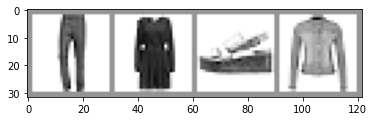

In [ ]:
#trainloaderのイテレータを取得
dataiter = iter(trainloader)
#イテレータでミニバッチ（画像４枚）を取得
images, labels = dataiter.next()

#make_grid関数で画像を書き込み、並べて表示できる
img_grid = torchvision.utils.make_grid(images)

#matplotlibで先ほどmake_gridで並べた画像を表示する。
matplotlib_imshow(img_grid, one_channel=True)

#tensorboardに並べた４枚の画像を書き込む。
writer.add_image('four_fashion_mnist_images', img_grid)


#３．TensorBoardを使用してモデルを検査する

In [ ]:
writer.add_graph(net, images)
writer.close()

#４．「Projector」を追加する

In [ ]:
#①追加のプログラム=============================
#TensorFlowパッケージが存在してしまっている場合は
#以下プログラムで一時しのぎが可能
#import tensorflow as tf
#import tensorboard as tb
#tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
#===============================================

#ヘルパー関数
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
images, labels = select_n_random(trainset.data, trainset.targets)

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.close()

ここで出るエラーについては以下を参考にしました。

https://github.com/pytorch/pytorch/issues/30966

##macでの階層指定
ターミナルでtensorboardを起動します。私のmac環境では、「/Python」の階層にJupyterノートを配置しています。そのため、コマンドのlogdirを次のように指定したらうまく動作しました。

tensorboard --logdir=/Python/runs

##windowsでの階層指定
AnacondaPromptでTensorBoardを起動します。私のwindows環境では、「C:\Users\ユーザー名（任意）\Python」階層にJupyterノートブックのPythonプログラムを保存しています。そのため、以下のようにlogdirを指定するとうまくいきました。

tensorboard --logdir=C:\Users\ユーザー名（任意）\Python\runs

##TensorBoardへのアクセス

ブラウザにて、

http://localhost:6006/

を入力してTensorBoardにアクセス。

#５. 訓練のトラッキングをする

In [ ]:
#ヘルパー関数
def images_to_probs(net, images):
    '''
    ニューラルネットに画像を入れて、予測を行い、出力である確率を取得します。
    '''
    output = net(images)
    #ニューラルネットの出力で最大の値の確率値を取得
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())#tensorからnumpyに
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    「images_to_probs」関数の予測値に、matplotlibの図を生成し加えます。
    '''
    preds, probs = images_to_probs(net, images)
    #予測と正解を一緒にしてミニバッチのデータをプロットします。
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
#net.cpu()#CPU利用

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

最後に、前のチュートリアルと同じモデルトレーニングコードを使用してモデルをトレーニングしますが、コンソールに出力するのではなく、1000バッチごとに結果をTensorBoardに書き込みます。これは、add_scalar関数を使用して行われます。

さらに、トレーニング中に、モデルの予測と、そのバッチに含まれる4つの画像の実際の結果を示す画像を生成します。

In [ ]:
running_loss = 0.0

#訓練ループ
for epoch in range(1):

    #ミニバッチループ
    for i, data in enumerate(trainloader, 0):

        #入力データ。「data」は [inputs, labels]のリスト。
        #【GPU】
        #inputs, labels = data[0].to(device) , data[1].to(device)
        #【CPU】
        inputs, labels = data#CPU

        #勾配の初期化
        optimizer.zero_grad()

        #順伝播、誤差計算、逆伝播、最適化を行います。
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        #損失の計算を行い、変数「runnning_loss」に累積
        running_loss += loss.item()
        if i % 1000 == 999:    #1000ミニバッチ毎に処理(画像4000枚ごと)

            #TensorBoardに1000ミニバッチの損失平均を書き込みます
            #add_scalarには、「データ名」「Y軸データの値」「X軸データ」で与えています。
            #X軸のデータとして、ミニバッチ数を計算しています。
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            #「predictions vs. actuals」を作成します。
            #1000ミニバッチ毎にひとつのミニバッチの正解を視覚的に表示します。
            writer.add_figure('predictions vs. actuals',
                            #【GPU】
                            #plot_classes_preds(net.cpu(), inputs.cpu(), labels.cpu()),#GPU利用時ここではCPUで処理
                            #【CPU】
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
            
            #【GPU】
            #net.cuda(), inputs.cuda(), labels.cuda()
            print("チェックポイント")
            #「running_loss」変数の初期化
            running_loss = 0.0
print('Finished Training')

これで、スカラータブを見て、トレーニングの15,000回の反復にわたってプロットされたランニングロスを確認できます。

さらに、学習を通じてモデルが任意のバッチで行った予測を確認できます。これを確認するには、「画像」タブを表示し、「予測vs実績」ビジュアライゼーションの下にスクロールしてください。これは、たとえば、わずか3000回のトレーニングを繰り返しただけで、モデルはシャツ、スニーカー、コートなどの視覚的に区別できるクラスをすでに区別できたことを示していますが、トレーニングの後半ほどは確信が持てません。

前のチュートリアルでは、モデルがトレーニングされた後、クラスごとの精度を調べました。ここでは、TensorBoardを使用して、各クラスの精度-再現率曲線（ここで適切な説明）をプロットします。

#６．TensorBoardでモデルを評価する

In [ ]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
# takes ~10 seconds to run
class_probs = []
class_preds = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        _, class_preds_batch = torch.max(output, 1)

        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_preds,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)